# Example 3: Logistic regression


The purpose of this example is to get familiar with *logistic regression* models. This example is an application of a logistic regression on NIST data, available in the 'sklearn.datasets' module.

For this tutorial, we will need the following libraries:

In [2]:
from sklearn.datasets import load_digits  # load the data digits
from sklearn.model_selection import train_test_split # train test split
from sklearn.linear_model import SGDClassifier # logistic regression with SGD
from sklearn.model_selection import cross_val_score # cross validation
from sklearn.base import BaseEstimator # create your own model
from sklearn.model_selection import cross_val_predict # prediction with CV
from sklearn.metrics import confusion_matrix # confusion matrix
from sklearn.metrics import precision_score, recall_score # precision and recall
from sklearn.metrics import f1_score # F1 score 
from sklearn.model_selection import cross_val_predict # CV (threshold score)
from sklearn.metrics import precision_recall_curve #precision and recall for all thresholds
from sklearn.metrics import roc_curve # ROC curve
import matplotlib.pyplot as plt
import numpy as np

## 1) Prepare the data NIST

The digits data (NIST) are available by default in the library, via the `load_digits` function of the datasets module.

In [3]:
data = load_digits() # load the data
data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

We create the data set `X` (variables to be explained) and the vector `y` (class labels).

In [4]:
X = data.data # predictors in X
y = data.target # target variable y

In [5]:
print(data.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

We can display the dimensions of `X` and `y`. The dataset contains 1797 observations, corresponding to images, each image is described by the intensity of the 64 pixels (variables) it contains (an image is of size $8\times 8$). Each image represents a handwritten digit, going from 0 to 9, this information is contained in $y$ (the class of each observation).

In [6]:
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


To visualize an image, you must first select a row of X, and reformat it in $8\times 8$ pixels format. Here is a visualization of the first 10 images. We add the class (contained in `y`) as a title to each image.

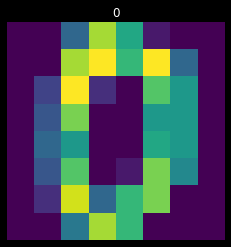

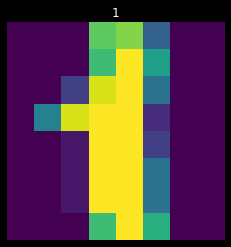

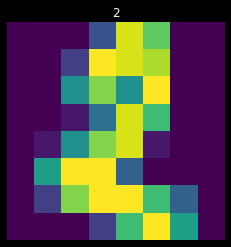

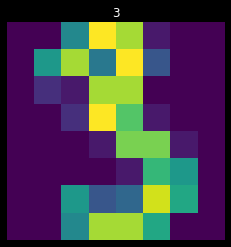

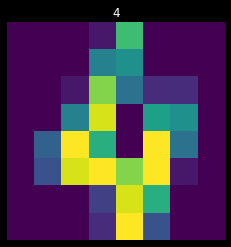

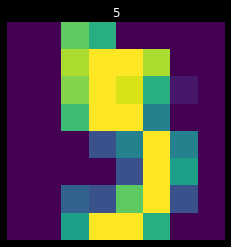

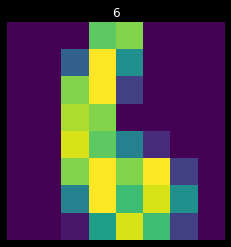

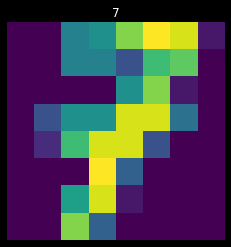

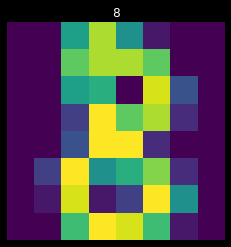

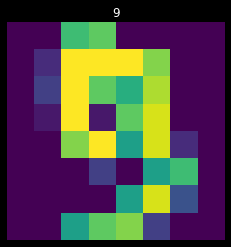

In [7]:
for i in range(10): # for i from 0 to 9
    image = X[i] # i-th image 
    image = image.reshape(8,8) # format in a 2D object
    plt.imshow(image) # plot axes
    plt.axis("off") # without axes
    plt.title(y[i]) # title = y (digit)
    plt.show() # show plot

Before proceeding to model fitting, we create a training sample and a test sample (20% of the observations constitute the test sample).

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 123)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1437, 64)
(1437,)
(360, 64)
(360,)


## 2) Binary classification 

In this example the variable $y$ can take more than two values (classes), in fact $y\in\{0,1,...,9\}$.

In order to do a logistic regression, we can convert this problem into a **binary classification** problem.
We will consider the digit 5, so the model will have to distinguish the images containing the digit 5 from the images containing another digit. We must therefore first modify the target variable $y$ (in the training sample and the test sample.

In [9]:
y_train_5 = (y_train == 5) # True if 5, False elsewhere
y_test_5 = (y_test == 5)

We can now proceed to the training of the model, here we will choose the `SGDClassifier` model. Be careful to choose the parameters `loss` and `alpha`, which are respectively the cost function (we will choose 'log').

In [10]:
# create an instance of the model
sgdclass = SGDClassifier(loss = 'log', random_state = 123)

# fitting using the training sample
sgdclass.fit(X_train, y_train_5)

SGDClassifier(loss='log', random_state=123)

We could now use this model to predict the presence of the digit 5 in an image.

In [11]:
# select the first image in the data
image = X[0]

# predict presence of 5
sgdclass.predict([image])

# 'False' (no 5 in this image)

array([False])

## 3) Performance measures

Evaluating a classification model requires more care than a regression model. Several measures can be considered.

A good way to evaluate a model is through **cross validation**. Here we use the `cross_val_score` function to evaluate our classifier. We use the $K$-fold cross validation method, which divides the training sample into $K = 3$ (for example) folds, the prediction and evaluation is performed on one fold using the model estimated on the remaining folds. In the example below, we take $K=3$, and we consider the measure 'accuracy', which is the proportion of well classified observations, in other words:

$$ \text{accuracy} = 1 - \text{error}$$

In [12]:
cross_val_score(sgdclass, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.99373695, 0.98121086, 0.99373695])

These results seem very satisfactory, but let's consider a "stupid" classifier, which never detects a 5 in an image, and measure its performance (accuracy).

In [13]:
class No5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return(np.zeros((len(X),1), dtype='bool'))

In [14]:
no5class = No5Classifier()
cross_val_score(no5class, X_train, y_train_5, cv = 3, scoring = 'accuracy').mean()

0.8990953375086986

This classifier obtains an average accuracy of about $90\%$. This is simply due to the fact that in the training sample, about $90\%$ of the images do not contain 5. This illustrates that the accuracy measure is not necessarily recommended when the class sizes are not balanced.

A better way to evaluate the performance is to consider the **confusion matrix**. For this we need to make predictions ($\hat{y}$), and compare them to our data ($y$). We use here the `cross_val_predict` function.

In [15]:
y_train_pred = cross_val_predict(sgdclass, X_train, y_train_5, cv = 3)
print(y_train_pred)

[False False False ... False  True False]


We can now construct the **confusion matrix** from the target classes (`y_train_5`) and the predicted classes (`y_train_pred`).

In [16]:
confusion_matrix(y_train_5, y_train_pred)

array([[1289,    3],
       [  12,  133]], dtype=int64)

Each row of the matrix represents an observed class (non-5 or 5), each column represents a predicted class.

The first row corresponds to the **negative class** (non-5). Among the images of the negative class, 1289 were correctly classified as non-5, they are the **true negatives** (VN). 3 images were classified as 5, these are the **false positives** (FP).

The second row corresponds to the **positive class** (5). Of the images in the positive class, 133 were correctly classified as 5, these are the **true positives** (VP). 12 images were classified as non-5, these are the **false negatives** (FN).

What would we get in case of a perfect classification?

In [17]:
y_train_perf = y_train_5
confusion_matrix(y_train_5, y_train_perf)

array([[1292,    0],
       [   0,  145]], dtype=int64)

Several metrics can be computed from the confusion matrix, such as **accuracy**:

$$ \text{accuracy} = \frac{VP}{VP+FP}$$

Another measure is usually used, the **recall**:

$$ \text{recall} = \frac{VP}{VP+FN}$$

We can compute these metrics with sklearn:

In [18]:
precision_score(y_train_5, y_train_pred)

0.9779411764705882

In [19]:
recall_score(y_train_5, y_train_pred)

0.9172413793103448

These two metrics are often considered as a single metric, the **F1 score**, which is very useful to compare the performance between two classifiers:

$$F_1 = 2\times\frac{\text{precision}\times\text{recall}}{\text{precision}+\text{recall}}$$

In [20]:
f1_score(y_train_5, y_train_pred)

0.9466192170818505

We have seen that logistic regression is based on a **decision threshold**, above which the predicted class is the positive class, negative otherwise. How to choose this threshold ? We can use the function `cross_val_predict`, which allows to return these decision thresholds, instead of the predictions.

In [40]:
y_scores = cross_val_predict(sgdclass, X_train, y_train_5, cv = 3, method = "decision_function")
print(y_scores) # threshold scores # c'est le score qui se trouve dans l'exponentielle de la formule de logit sans le moins
print(1/(1+np.exp(-y_scores))) # mannually compute the predicted probabilities or simply use the method = "predict_proba"

[-5716.76512871 -3551.68392059 -4445.87663926 ... -1497.3588711
   857.31421132 -2481.07513106]
[0. 0. 0. ... 0. 1. 0.]


C:\Users\gomez\AppData\Local\Temp/ipykernel_18940/2769037268.py:3: RuntimeWarning: overflow encountered in exp
  print(1/(1+np.exp(-y_scores))) # mannually compute the predicted probabilities or simply use the method = "predict_proba"


The function `precision_recall_curve` allows to compute the value of precision and recall for all possible decision thresholds. Below the precision in blue, and the recall in green.

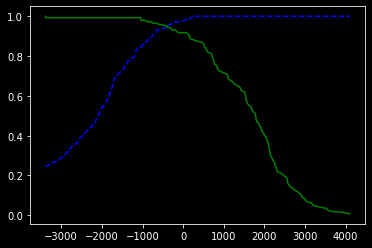

In [41]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
plt.show() # blue : precision and green the recall

Another visualization is to display the precision as a function of the recall.

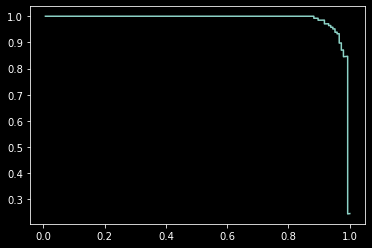

In [23]:
plt.plot(recalls[:-1],precisions[:-1])
plt.show()

Now let's assume that we have a $99%$ accuracy target. We need to find the threshold at which we have:
$$ \text{Precision}>=0.99$$

In [24]:
seuil = thresholds[np.argmax(precisions >= 0.99)]

y_train_pred_99 = (y_scores >= seuil) # booleen

In [25]:
precision_score(y_train_5, y_train_pred_99)

0.9923664122137404

In [26]:
recall_score(y_train_5, y_train_pred_99)

0.896551724137931

Finally, a visualization widely used in binary classification is the **ROC curve**, representing the true positive rate versus the false positive rate. It is common to calculate the **area under the curve** (AUC) as an evaluation metric.

<function matplotlib.pyplot.show(close=None, block=None)>

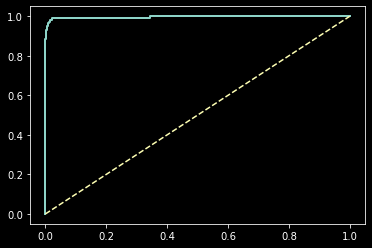

In [27]:
tfp, tvp, thresholds = roc_curve(y_train_5, y_scores) #similar to precision_recall_curve

plt.plot(tfp,tvp, linewidth = 2)
plt.plot([0,1],[0,1], '--')
plt.show

## 4) Multiclass classification

We now try to predict the ten classes ($K>2$), the function `SGDClassifier` is adapted to this case, we proceed the same way as before:

[0]


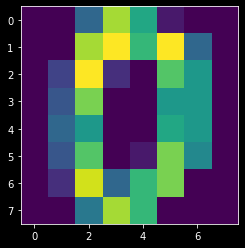

In [28]:
multiclass = SGDClassifier(loss = 'log') # create a model
multiclass.fit(X_train, y_train) # now y takes values between 0 & 9
print(multiclass.predict([image])) # prediction for one image

plt.imshow(image.reshape(8,8))
plt.show()

As we can see, the function adapts to the multi-class case, and will automatically choose a "One versus rest" (OVR) or "One versus all" (OVA) strategy. What happens if we compute the decision scores?

In [29]:
score = multiclass.decision_function([image])

In [30]:
print(score) # 10 scores (one per class)

[[ 2467.18466075 -3659.6925599  -2945.64556216 -1612.54596357
  -3015.83939202 -2807.59531512 -2142.17959227  -769.87703699
  -1728.03802352 -1003.45863892]]


The highest score is observed for the first class (0). Indeed:

In [31]:
np.argmax(score)

0

   Compute the confusion matrix:

In [32]:
y_train_pred = cross_val_predict(multiclass, X_train, y_train, cv = 3) # CV predictions

conf = confusion_matrix(y_train, y_train_pred) # confusion matrix
print(conf)

[[138   0   1   0   0   0   0   0   0   0]
 [  0 123   2   7   0   1   1   0  11   3]
 [  0   0 140   0   0   0   0   0   1   0]
 [  0   1   1 142   0   2   0   0   3   1]
 [  0   0   0   0 132   1   1   1   3   1]
 [  0   1   0   0   0 140   1   0   0   3]
 [  0   0   0   0   0   1 136   0   1   0]
 [  0   0   0   1   0   1   0 144   0   2]
 [  0  11   1   3   0   2   0   0 118   2]
 [  0   2   0   5   0   1   0   2   3 139]]


We obtain a visual representation of this matrix.

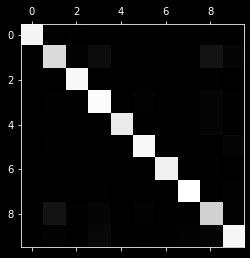

In [33]:
plt.matshow(conf,cmap = plt.cm.gray)

Here we divide the matrix values by the sum of the rows, we obtain a normalized confusion matrix.
We set to 0 the diagonal coefficients to focus only on the errors, and we display the new matrix.
We observe a lot of errors between the numbers 1 and 8.

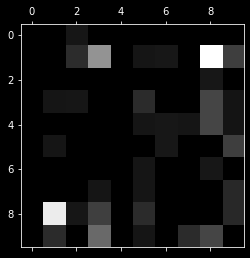

In [34]:
row_sums = conf.sum(axis = 1)
norm_conf = conf/row_sums
np.fill_diagonal(norm_conf,0)

plt.matshow(norm_conf, cmap = plt.cm.gray)
plt.show()

For these two values (1 and 8) we will analyze the errors.

In [35]:
# we isolate the 1 predicted 1, the 8 predicted 8, the 1 predicted 8, and the 8 predicted 1
X11 = X_train[(y_train == 1) & (y_train_pred == 1)] # vrais 1
X88 = X_train[(y_train == 8) & (y_train_pred == 8)] # vrais 8
X18 = X_train[(y_train == 1) & (y_train_pred == 8)] # faux 8
X81 = X_train[(y_train == 8) & (y_train_pred == 1)] # faux 1

True 1 predicted 1:

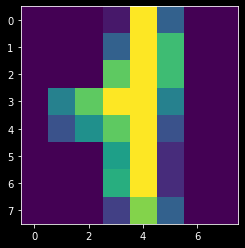

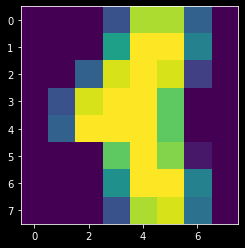

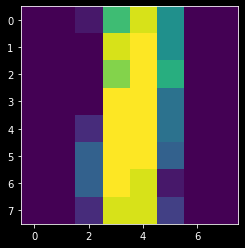

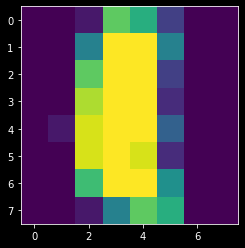

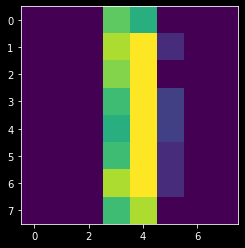

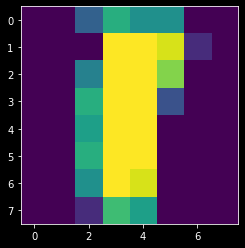

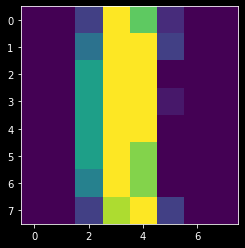

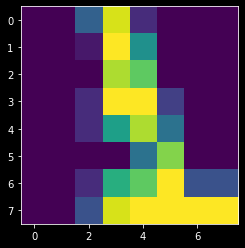

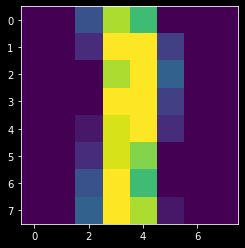

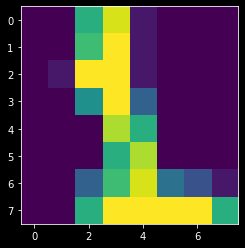

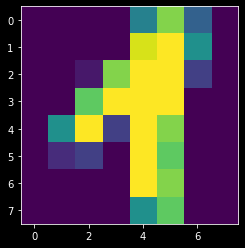

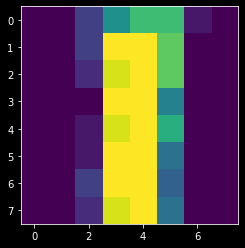

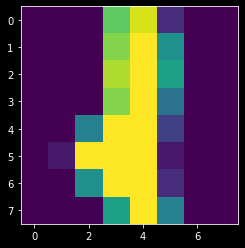

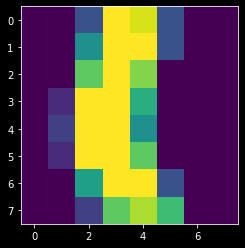

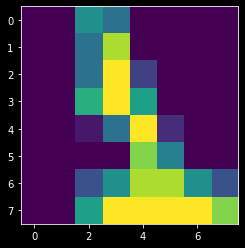

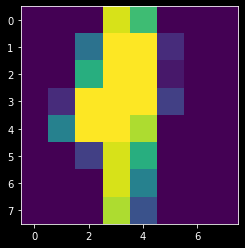

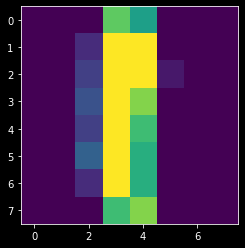

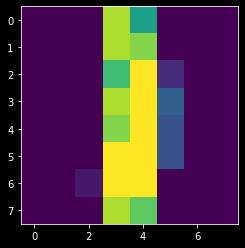

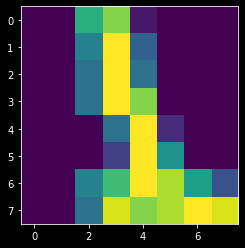

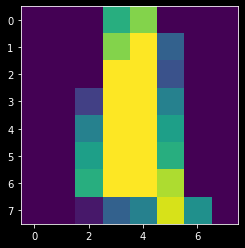

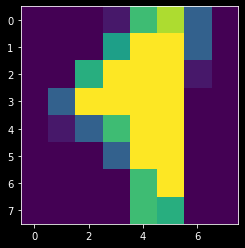

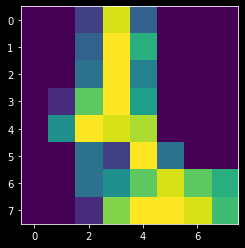

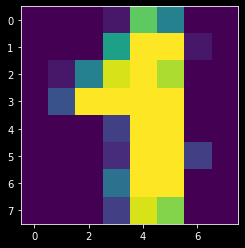

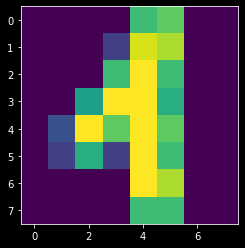

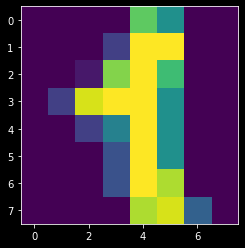

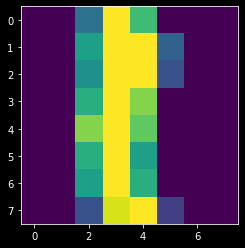

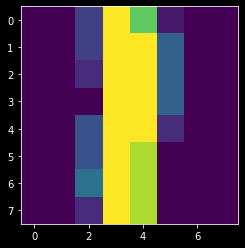

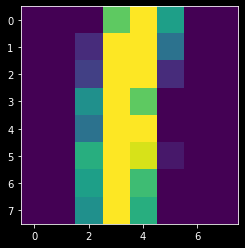

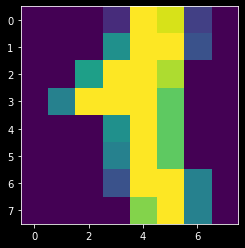

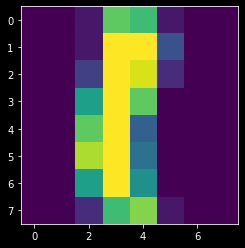

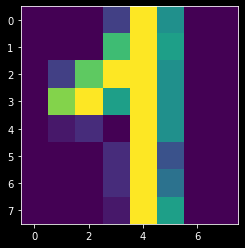

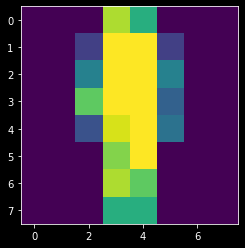

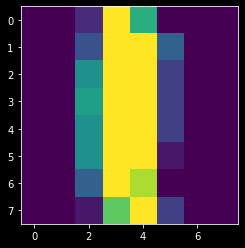

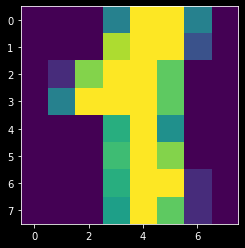

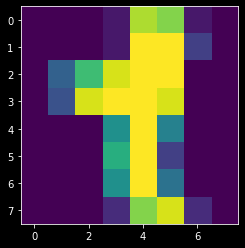

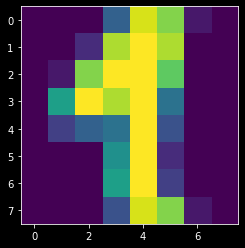

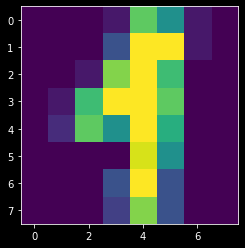

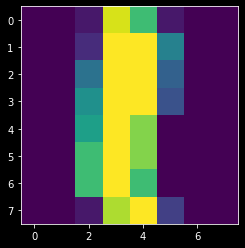

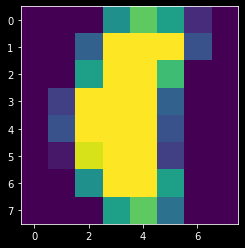

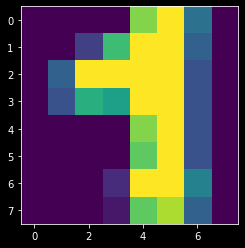

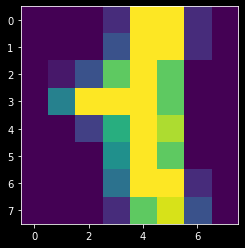

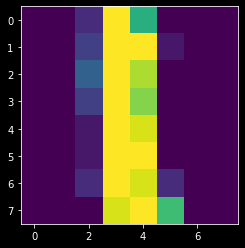

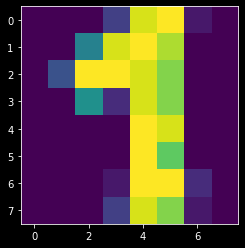

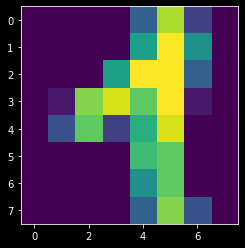

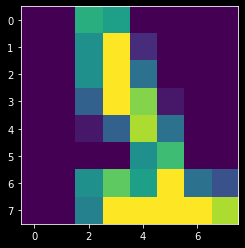

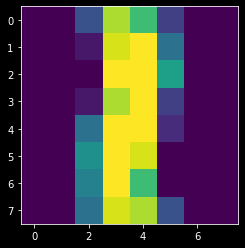

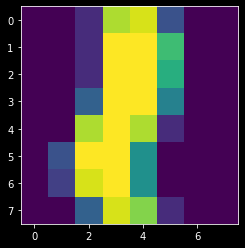

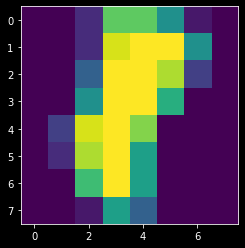

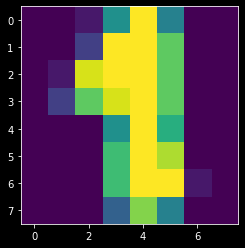

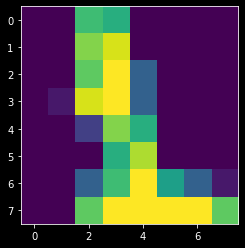

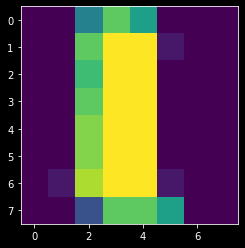

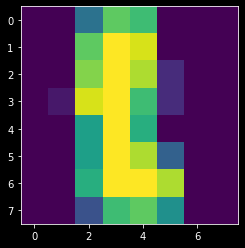

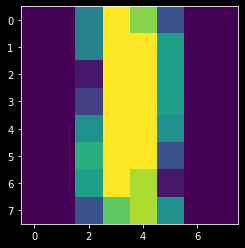

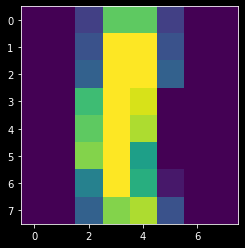

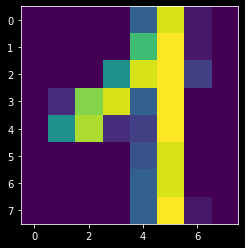

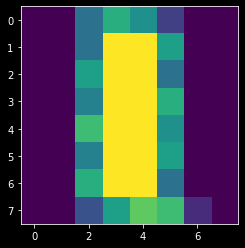

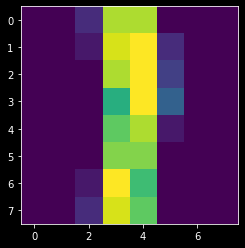

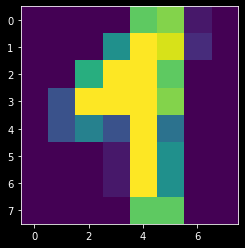

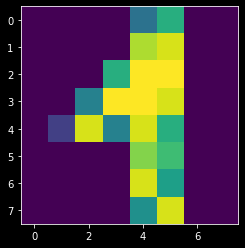

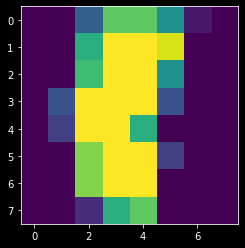

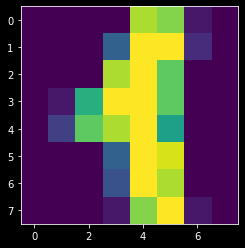

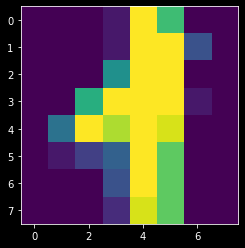

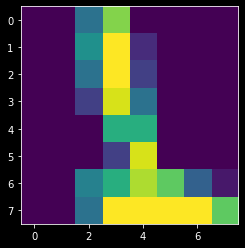

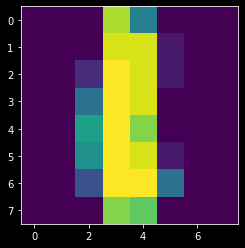

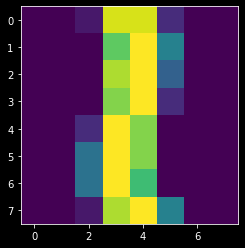

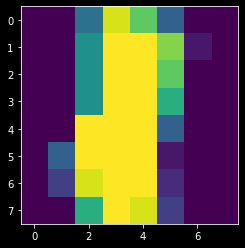

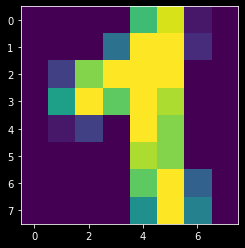

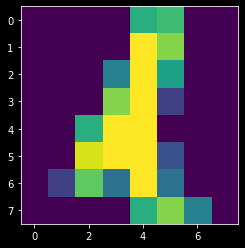

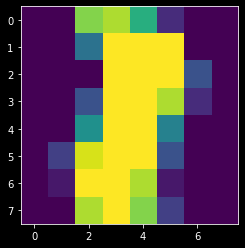

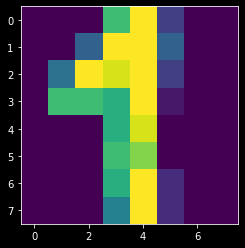

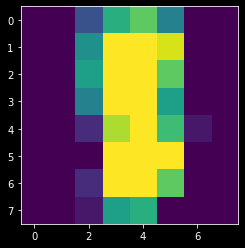

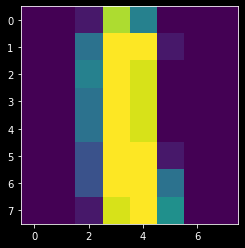

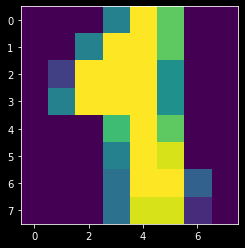

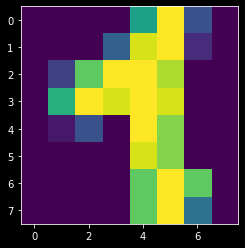

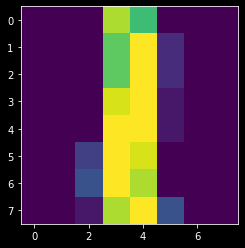

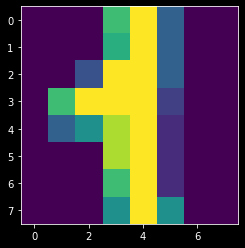

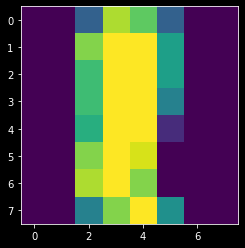

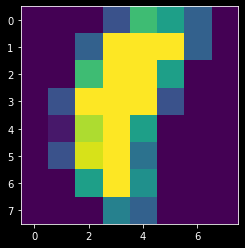

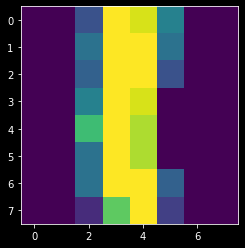

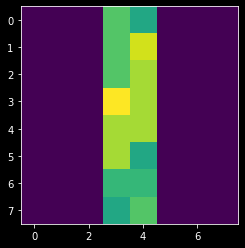

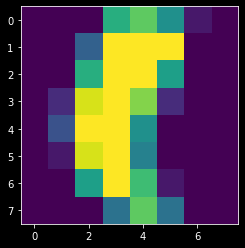

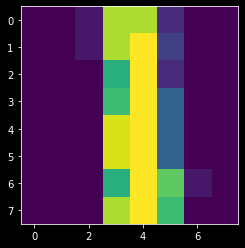

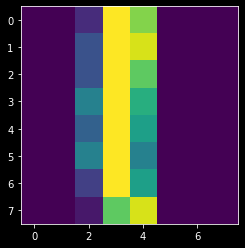

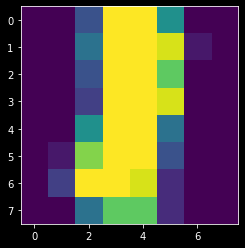

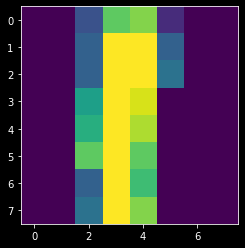

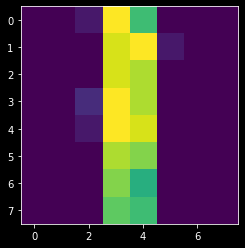

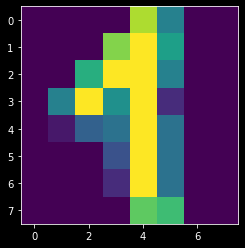

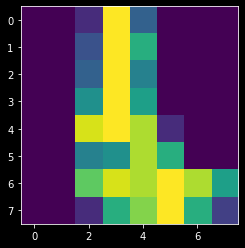

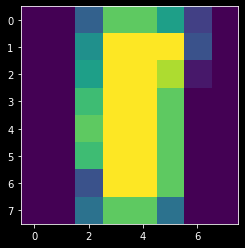

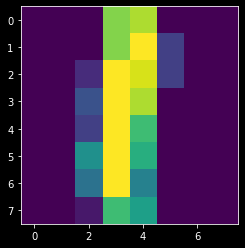

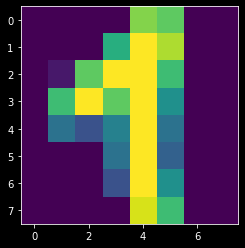

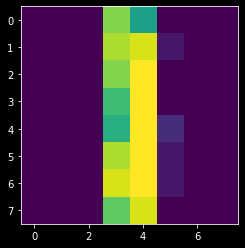

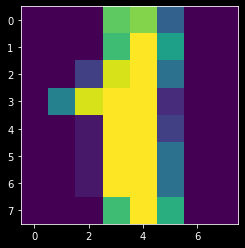

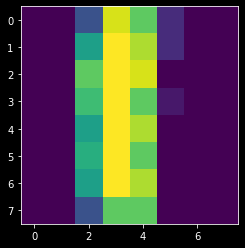

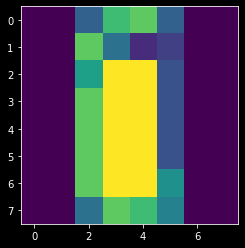

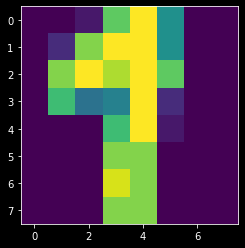

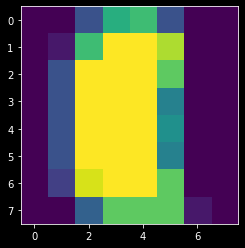

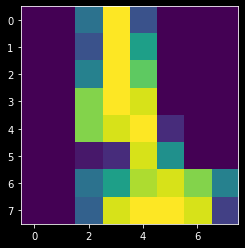

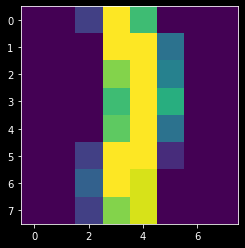

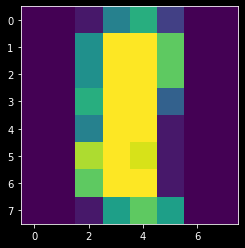

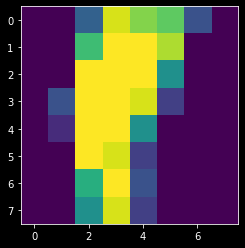

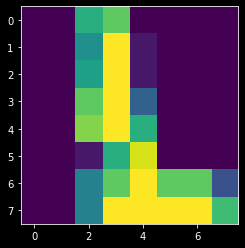

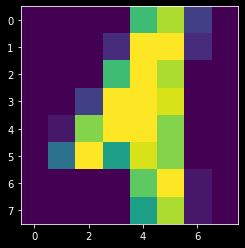

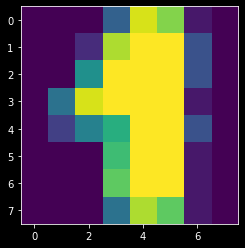

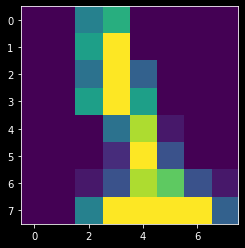

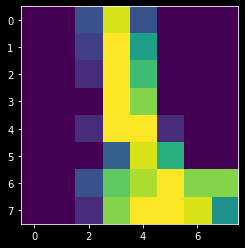

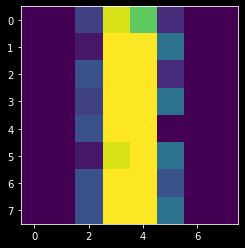

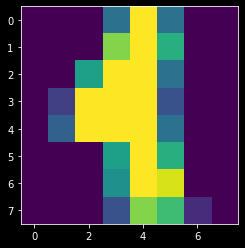

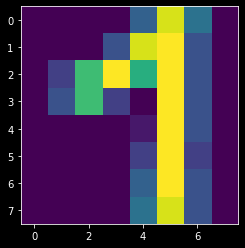

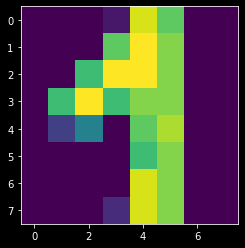

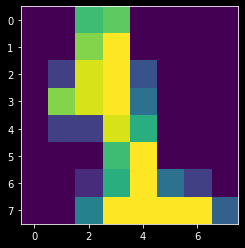

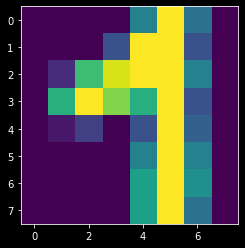

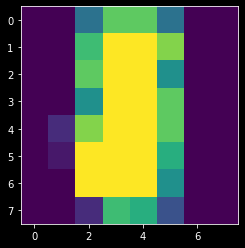

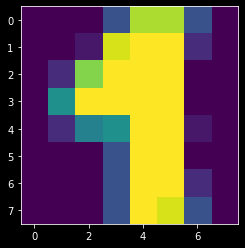

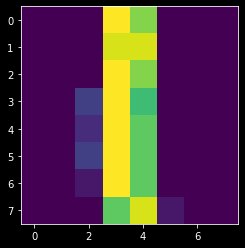

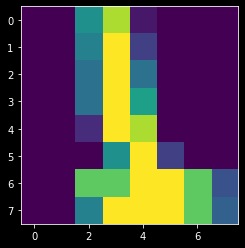

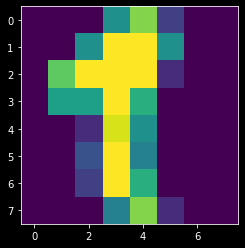

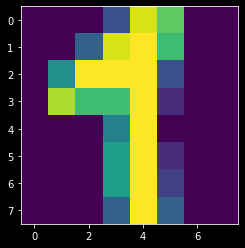

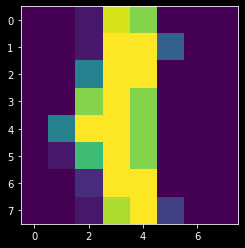

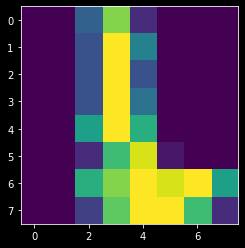

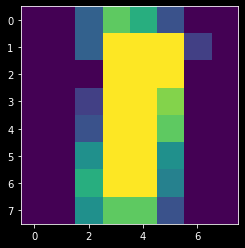

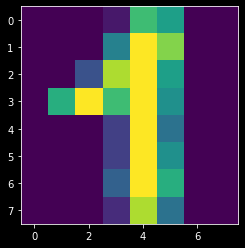

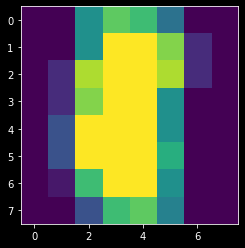

In [36]:
for im in X11:
    plt.imshow(im.reshape(8,8))
    plt.show()

True 8 predicted 8:

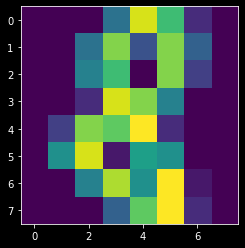

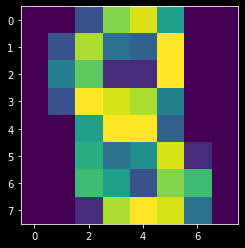

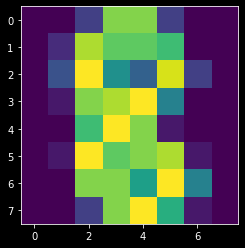

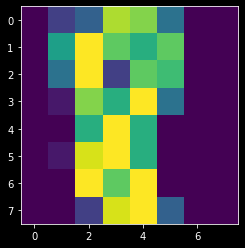

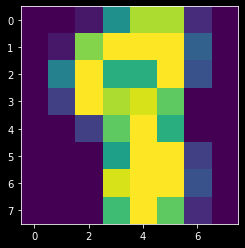

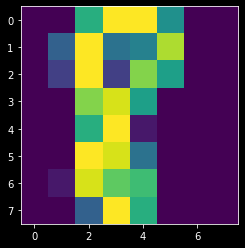

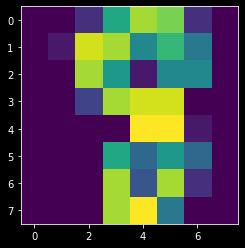

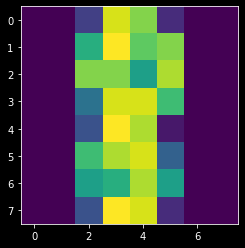

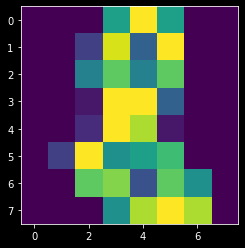

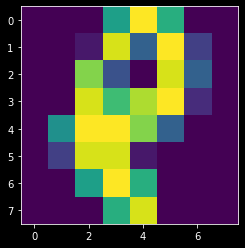

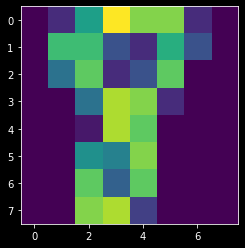

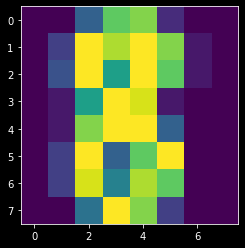

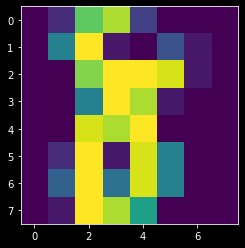

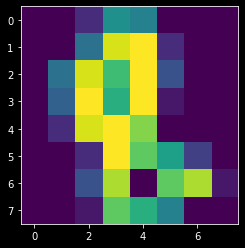

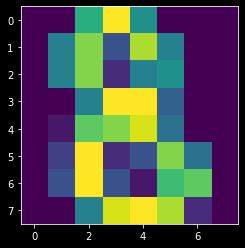

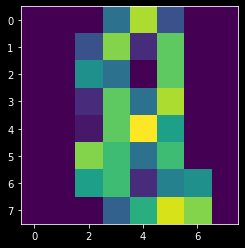

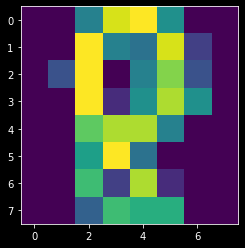

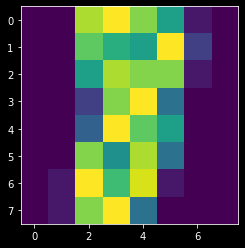

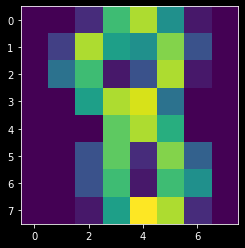

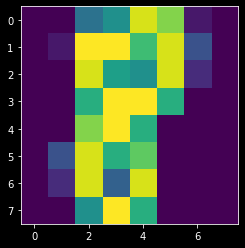

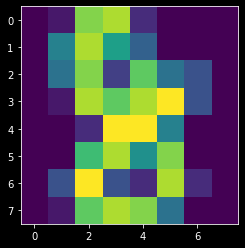

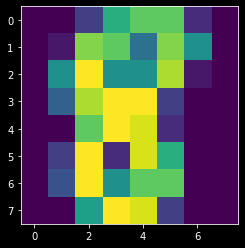

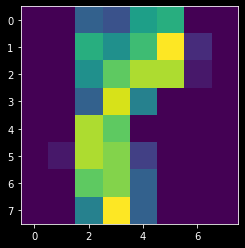

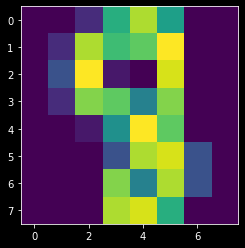

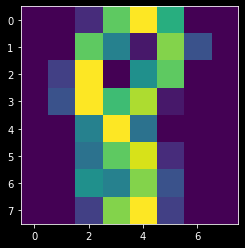

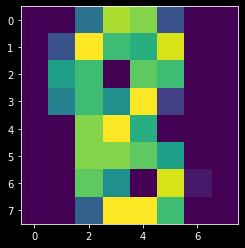

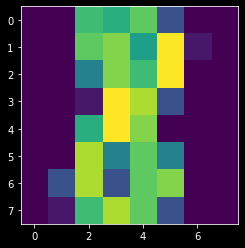

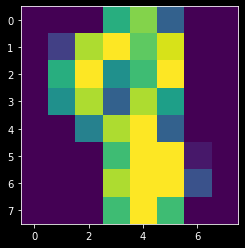

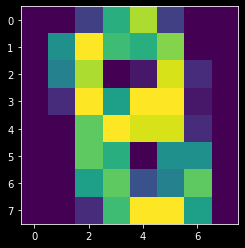

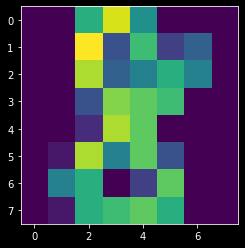

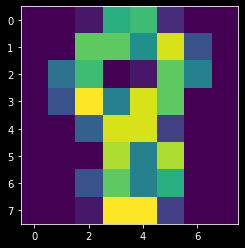

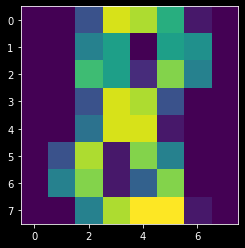

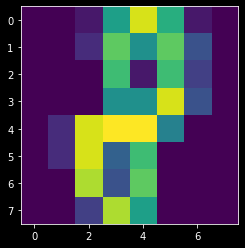

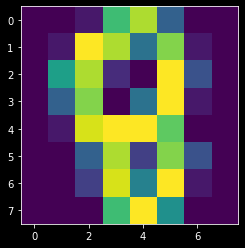

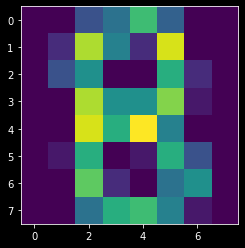

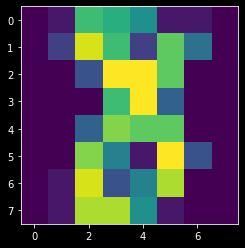

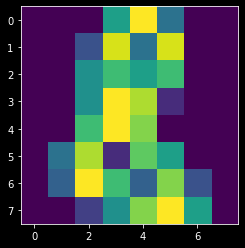

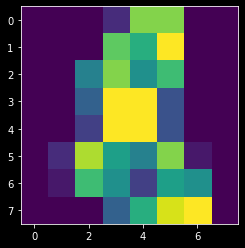

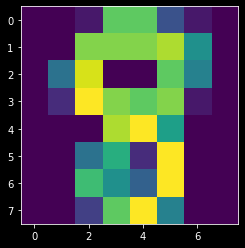

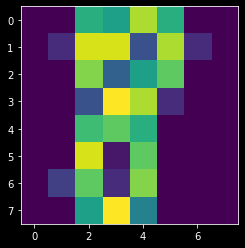

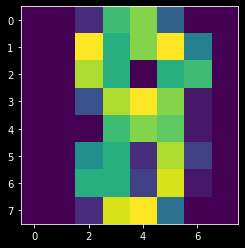

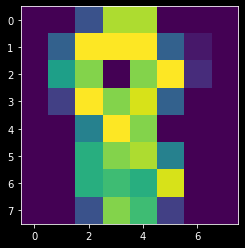

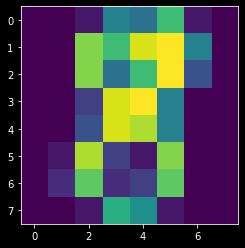

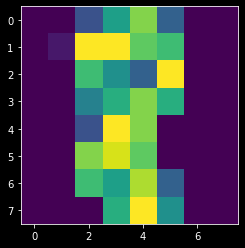

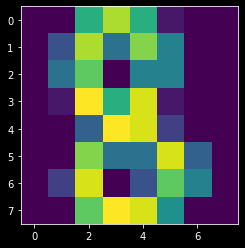

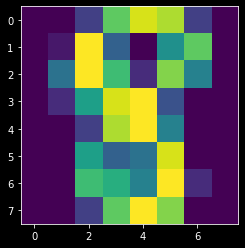

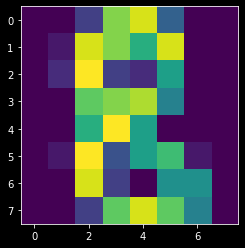

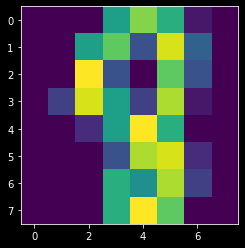

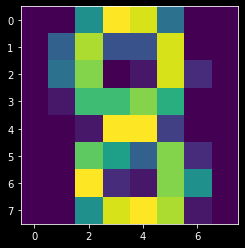

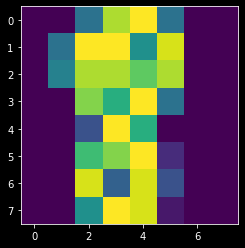

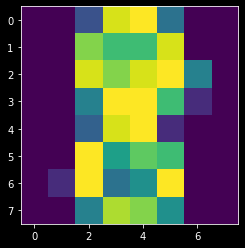

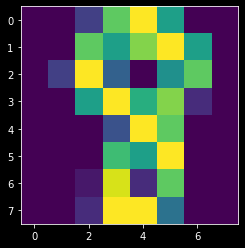

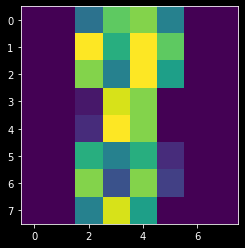

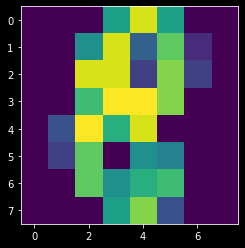

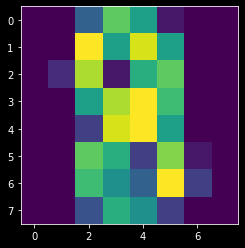

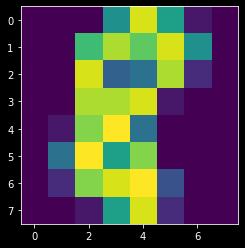

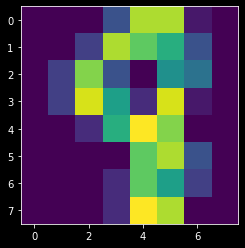

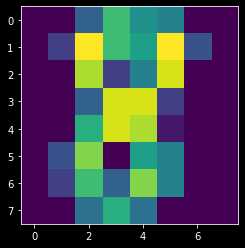

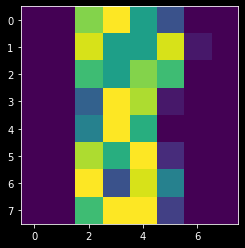

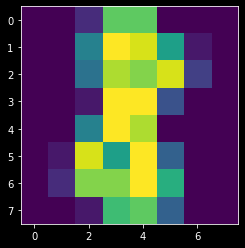

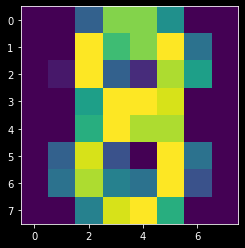

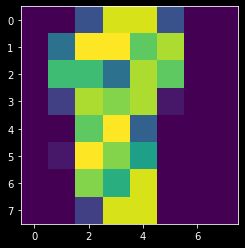

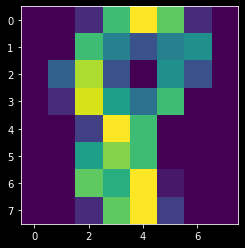

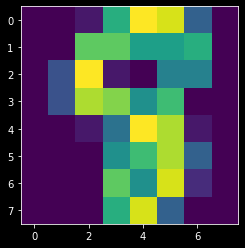

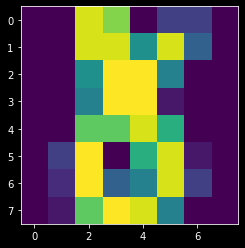

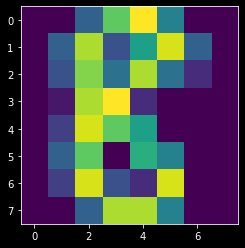

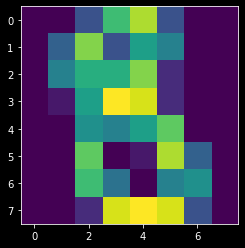

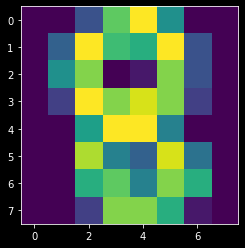

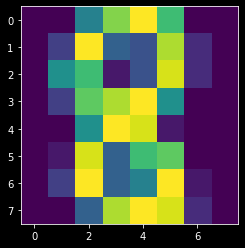

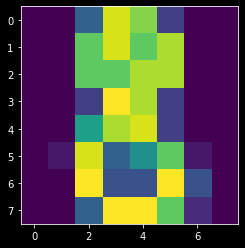

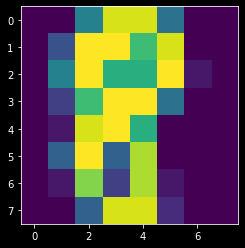

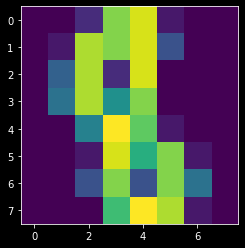

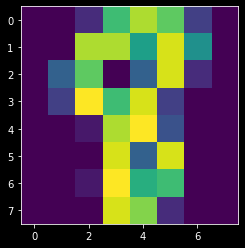

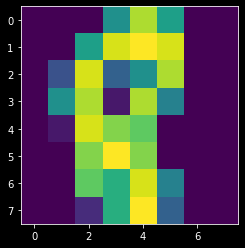

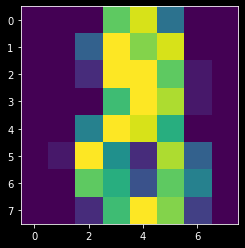

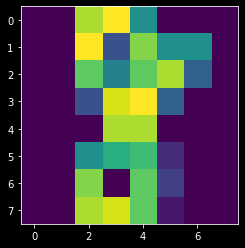

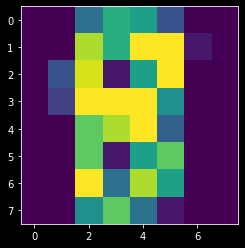

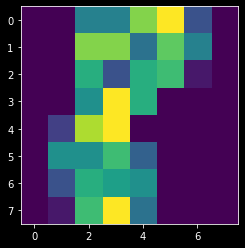

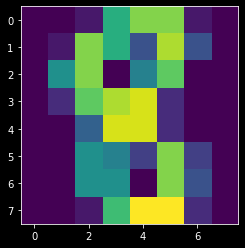

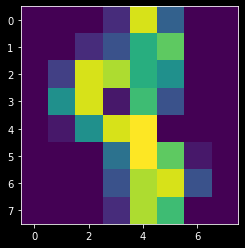

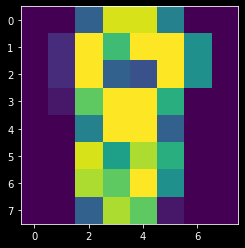

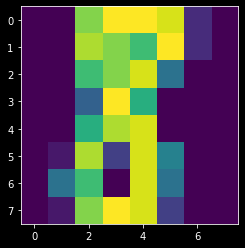

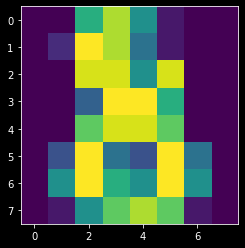

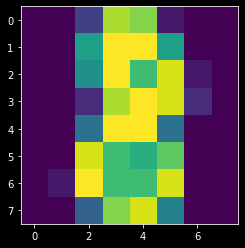

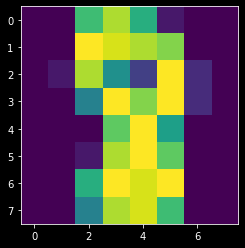

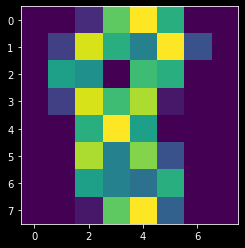

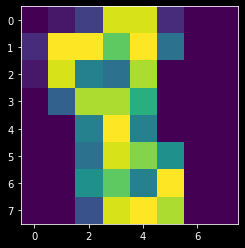

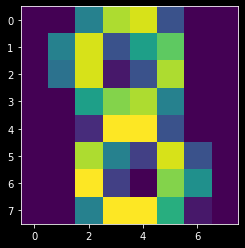

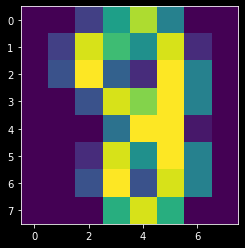

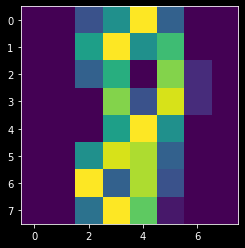

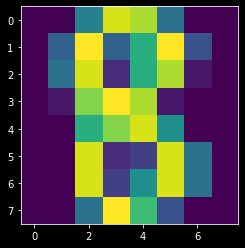

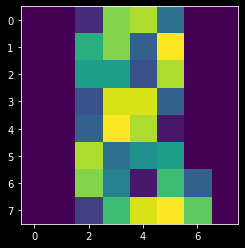

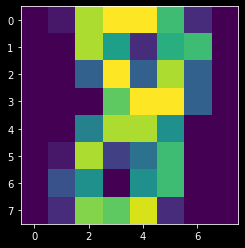

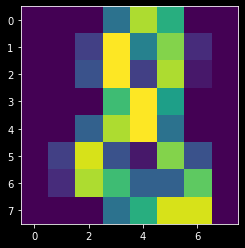

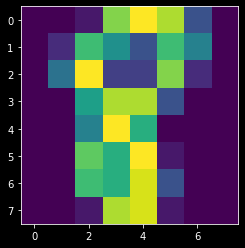

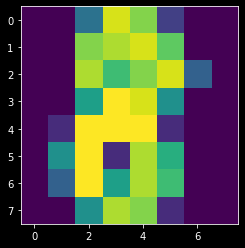

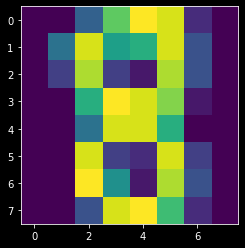

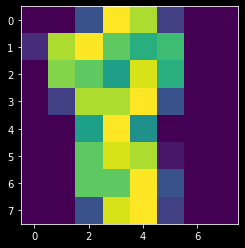

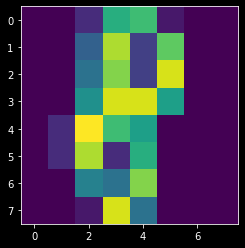

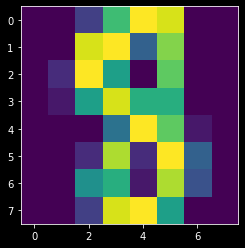

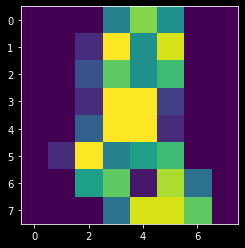

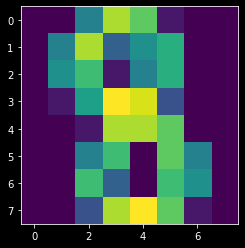

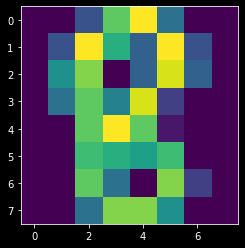

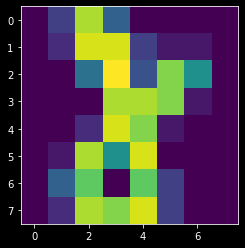

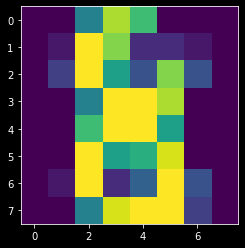

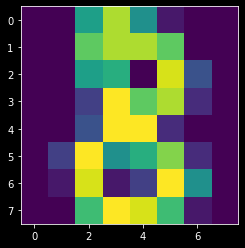

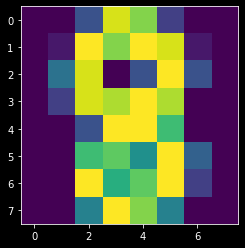

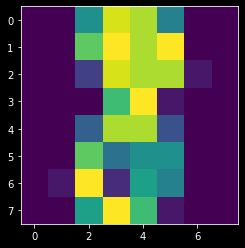

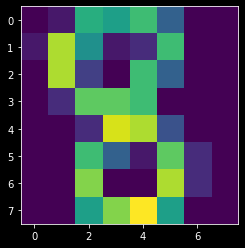

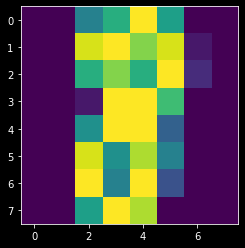

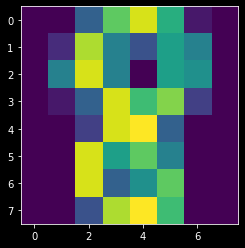

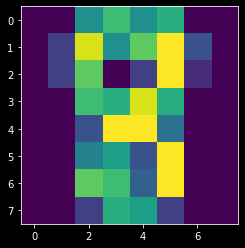

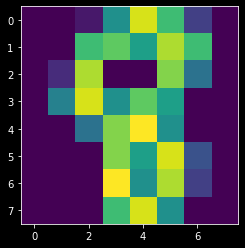

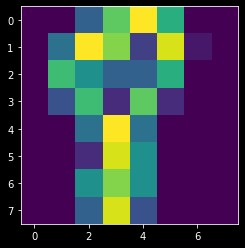

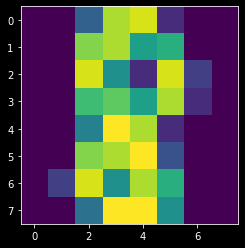

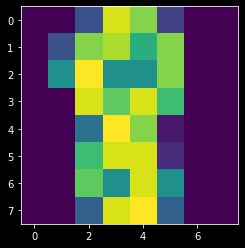

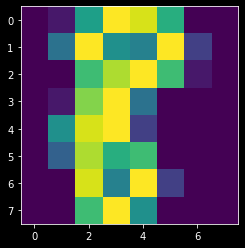

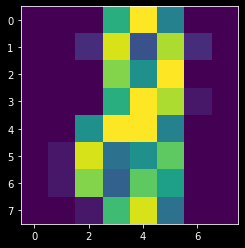

In [37]:
for im in X88:
    plt.imshow(im.reshape(8,8))
    plt.show()

True 1 predicted 8:

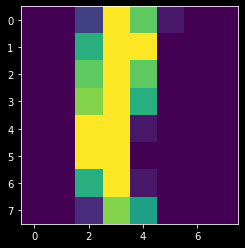

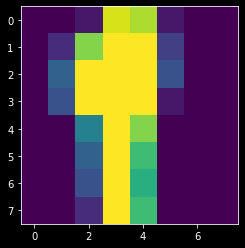

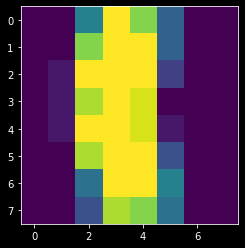

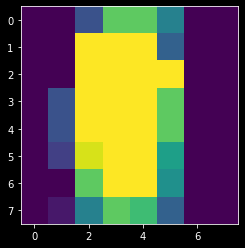

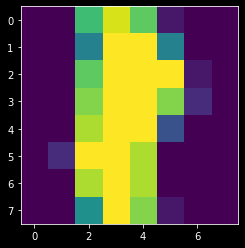

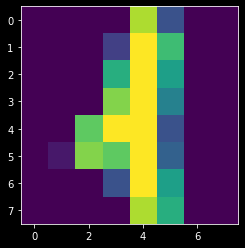

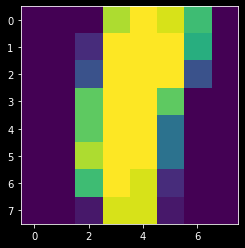

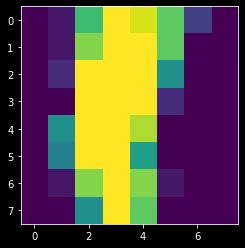

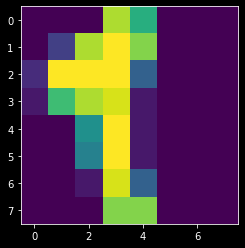

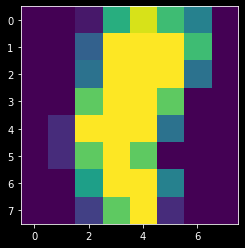

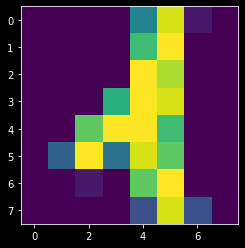

In [38]:
for im in X18:
    plt.imshow(im.reshape(8,8))
    plt.show()

True 8 predicted 1:

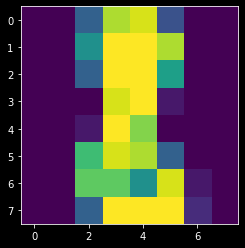

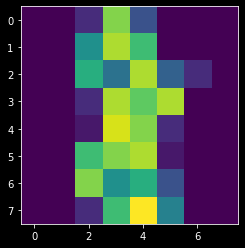

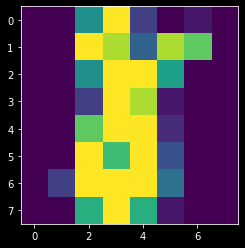

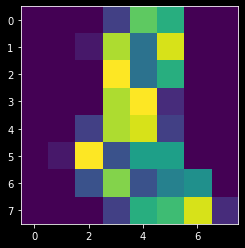

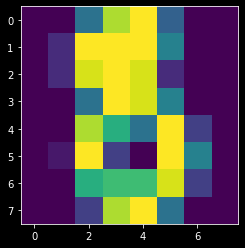

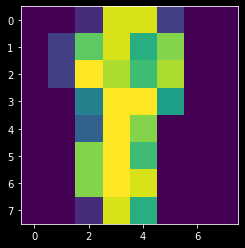

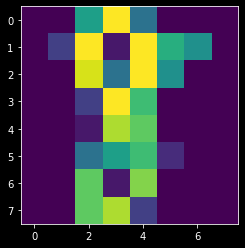

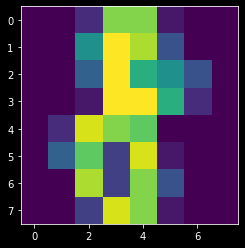

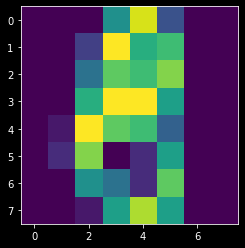

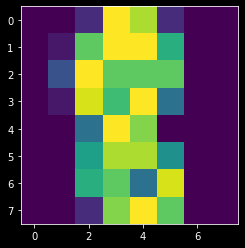

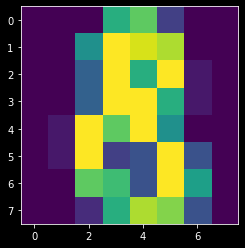

In [39]:
for im in X81:
    plt.imshow(im.reshape(8,8))
    plt.show()

## Exercice

Reproduce this example using another dataset.